# RES Forecasting - Wind Power Forecasting

The Greek RES dataset was created from a number of different sources, by combining energy generation, geolocation and weather data. The dataset contains geolocation, weather and RES energy production data of the top contributors of wind and solar energy that contribute the 20% of the RES power in the Greek energy grid. The weather data were collected from a weather forecast API and represent the last generated forecast for each installation.

The data were collected from the following sources:

* RES energy production from [ENTSO-E](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show)
* Weather data captured using the [Stormglass API](https://docs.stormglass.io/#/weather?id=point-request)
* Wind turbine and PV installations geolocation data, for the locations that aquired operation licence as found in [Regulatory Authority for Energy (RAE)](https://geo.rae.gr/)

More information regarding energy licencing http://www.opengov.gr/minenv/?p=1031

The idea behind this exercise is to explore the predictability of the **wind energy production for the Greek energy grid** by using only aggregated weather information from the top 20% of wind park installations. The forecast horizon for this project is one week, and the predictions are performed by applying a rolling forecast with one day window and using as features *the next day's weather forecast* and *the previous day energy production*. Additionally, a number of temporal features are used as well, in an attemp to describe the seasonality of the timeseries. Features such as the *month, hour, day, day of week and day of year* are encoded with polar coordinates to capture their cyclical nature.


The study focuses on linear and non-linear statistical models and some hybrid combination of those
* Linear Regression
* Ridge Regression
* Elastic Net Regression
* Random Forest Regression
* Extreme Gradient Boosting
* Facebook Prophet
* Hybrid Facebook Prophet with Random Forest Regression
* Hybrid Facebook Prophet with Extreme Gradient Boosting


For the experiments, 4 years of weather and energy data were collected from 2017 to 2020. Namely, 5 different training and testing datasets have been developed, for each energy source, and the testing is applied on specific weeks of **March, May, July, October and December of 2020**. The forecast evaluation is perfoemed using MAE and RMSE as well as an error visualization using violin plots.

## 1. Introduction
### 1.1 Initialization

In [1]:
import json
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import geopandas as gpd
from shapely import wkt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
sns.set_theme(style="white")
# sns.set()

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Custom library that implements visualization fuctions and the rolling forecast
from helper_functions import ModelEvaluation 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.2 Greek Wind Park Installation Visualization

The geolocation data also contain information of the maximum energy capacity of each wind park installation. Using a violin plot for the distribution of the energy capacity, it becomes clear that it is heavily long-tailed distribution, which means that most of the energy generation capacity is contained in a small number of installations.

> Based on this long tail distribution, the hypothesis is borned that we can forecast the total wind energy production using aggregated weather information from the locations of the wind turbine installations of the top 20% wind energy contributors

In [2]:
# Load wind Data
geo_wind_df = pd.read_csv('data/Geolocation_data/V_SDI_R_AIOLIKA13.csv')
geo_wind_df.sort_values(by = 'power_mw', ascending=False, inplace=True)

geo_wind_df.loc[:, 'geometry'] = geo_wind_df['geometry'].apply(wkt.loads)

# Convert geo string to MultiPolygons
geo_wind_gdf = gpd.GeoDataFrame(geo_wind_df, geometry='geometry' )
# Get representative point for each polygon
geo_wind_gdf['representative_lon'] = geo_wind_gdf['geometry'].representative_point().x
geo_wind_gdf['representative_lat'] = geo_wind_gdf['geometry'].representative_point().y
geo_wind_gdf.shape

(316, 20)

Long tail distribution of the energy capacity of the licenced Wind Turbine installations in Greece

In [3]:
import plotly.express as px
fig = px.violin(x=geo_wind_gdf["power_mw"], 
          title='Distribution of the energy capacity of the licenced Wind Turbine installations in Greece', 
          box=True, # draw box plot inside the violin
          points='all')
fig.show()

A long tail distribution is observed in the wind power capacity data, meaning that most of the production is achieved by a small number of wind park installations. As seen below the 20% of the total wind power generation is produced by 18 wind park installations from a total of 316.

In [4]:
top_geo_wind_gdf = geo_wind_gdf[geo_wind_gdf['power_mw'].cumsum() < geo_wind_gdf['power_mw'].sum() * 20 / 100]
top_geo_wind_gdf.shape

(18, 20)

### 1.3 Greek Wind Park Installations Map
Wind turbine installations in Greece and the top 20% contributors
![Wind Park Installations in Greece](./map_config/wind_parks.png)

In [23]:
# # Loading map config
# with open('map_config/wind_map_config.json', 'r') as map_file:
#     wind_map_config = json.loads(map_file.read())

In [24]:
# from keplergl import KeplerGl

# wind_map = KeplerGl(height=600, width=800)

# wind_map.add_data(geo_wind_gdf, 'Greek Wind Park Installations')
# wind_map.add_data(top_geo_wind_gdf, 'Top Greek Wind Park Installations')

# # Load styling    
# wind_map.config = wind_map_config
# wind_map

In [7]:
# # Saving map style
# with open('map_config/wind_map_config.json', 'w') as map_file:
#     json.dump(wind_map.config, map_file)

## 2. Experiments

The solar energy production forecast is performed in a weekly horizon using a rolling prediction for each day of the week. In order to have a thorough evaluation of the prediction, 5 weeks across different seasons are chosen for the test. The first day of each week is Monday, the following dates are used to indicate each week:
* 2020-03-09
* 2020-05-18
* 2020-07-20
* 2020-10-12
* 2020-12-14

In [8]:
target_dates =  ["2020-03-09", "2020-05-18", "2020-07-20", "2020-10-12", "2020-12-14"]
rolling_eval = ModelEvaluation()

### 2.1 Linear Regression


Starting Linear Regression for week 2020-03-09 for week 2020-03-09...



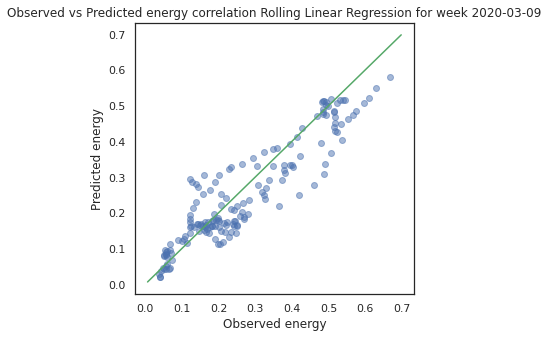

Root Mean Squared Error (RMSE): 0.06553
Mean Absolute Error (MAE): 0.05055
Finished forecasting week 2020-03-09 in 0:00:00.658398

Starting Linear Regression for week 2020-05-18 for week 2020-05-18...



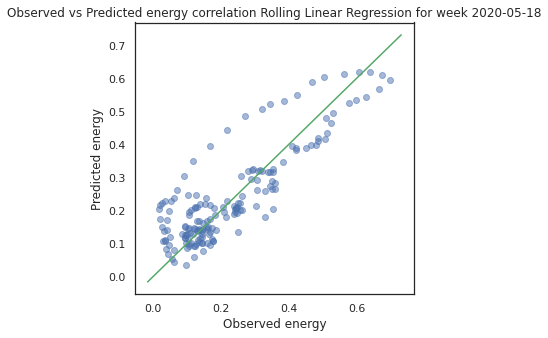

Root Mean Squared Error (RMSE): 0.08273
Mean Absolute Error (MAE): 0.06216
Finished forecasting week 2020-05-18 in 0:00:00.466384

Starting Linear Regression for week 2020-07-20 for week 2020-07-20...



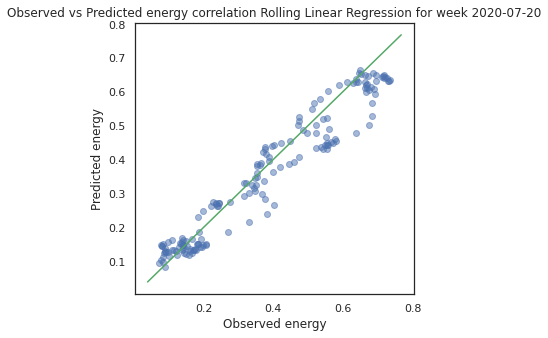

Root Mean Squared Error (RMSE): 0.05912
Mean Absolute Error (MAE): 0.04674
Finished forecasting week 2020-07-20 in 0:00:00.452903

Starting Linear Regression for week 2020-10-12 for week 2020-10-12...



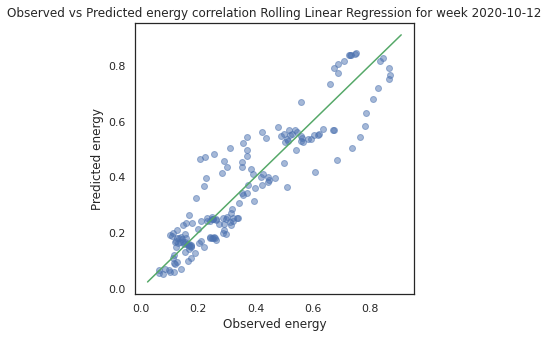

Root Mean Squared Error (RMSE): 0.08633
Mean Absolute Error (MAE): 0.06711
Finished forecasting week 2020-10-12 in 0:00:00.696347

Starting Linear Regression for week 2020-12-14 for week 2020-12-14...



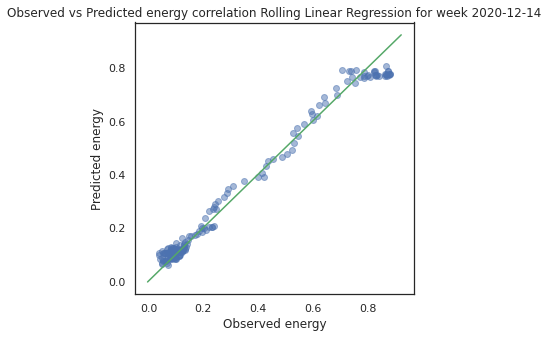

Root Mean Squared Error (RMSE): 0.03813
Mean Absolute Error (MAE): 0.02881
Finished forecasting week 2020-12-14 in 0:00:00.569202


In [9]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Prediction
   clf_linreg = LinearRegression()
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_linreg, 
                                                      'Linear Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.2 Ridge Regression


Starting Ridge Regression for week 2020-03-09 for week 2020-03-09...



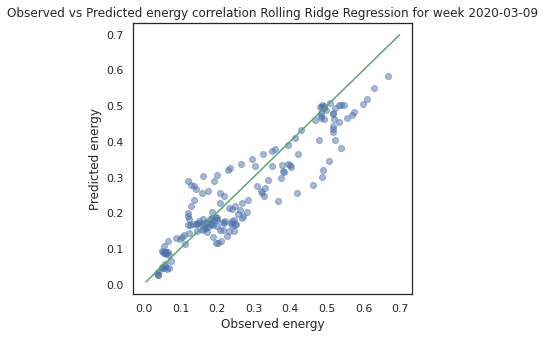

Root Mean Squared Error (RMSE): 0.06591
Mean Absolute Error (MAE): 0.05086
Finished forecasting week 2020-03-09 in 0:00:11.151553

Starting Ridge Regression for week 2020-05-18 for week 2020-05-18...



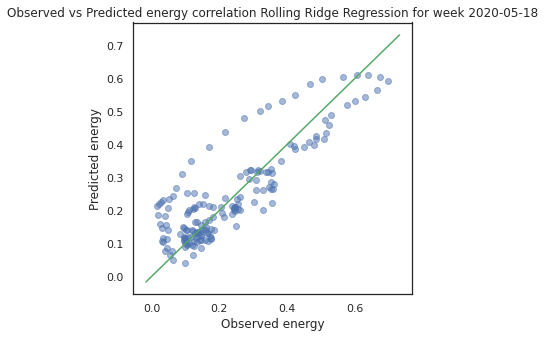

Root Mean Squared Error (RMSE): 0.08267
Mean Absolute Error (MAE): 0.06096
Finished forecasting week 2020-05-18 in 0:00:08.831461

Starting Ridge Regression for week 2020-07-20 for week 2020-07-20...



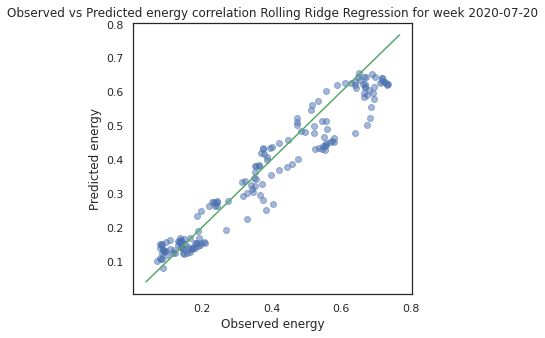

Root Mean Squared Error (RMSE): 0.06112
Mean Absolute Error (MAE): 0.04854
Finished forecasting week 2020-07-20 in 0:00:08.402242

Starting Ridge Regression for week 2020-10-12 for week 2020-10-12...



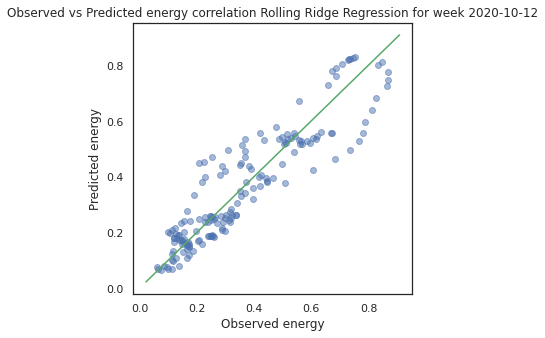

Root Mean Squared Error (RMSE): 0.08661
Mean Absolute Error (MAE): 0.06688
Finished forecasting week 2020-10-12 in 0:00:11.439653

Starting Ridge Regression for week 2020-12-14 for week 2020-12-14...



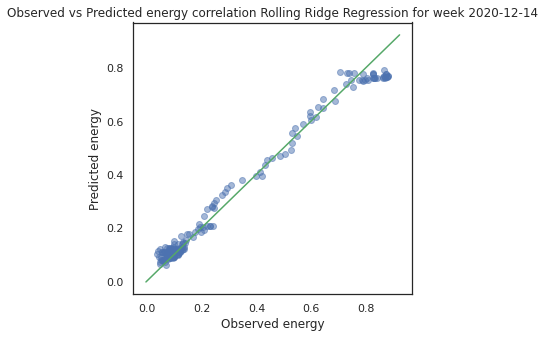

Root Mean Squared Error (RMSE): 0.04119
Mean Absolute Error (MAE): 0.03068
Finished forecasting week 2020-12-14 in 0:00:13.059612


In [10]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   alpha_space = np.logspace(-3, 0, 20)
   param_grid = {'alpha': alpha_space}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_ridge = GridSearchCV(Ridge(normalize = True),
                                 param_grid,
                                 cv = tscv,
                                 n_jobs = 3)
   
   # Prediction
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_ridge, 
                                                      'Ridge Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.3 Elastic Net Regression


Starting Elastic Net Regression for week 2020-03-09 for week 2020-03-09...



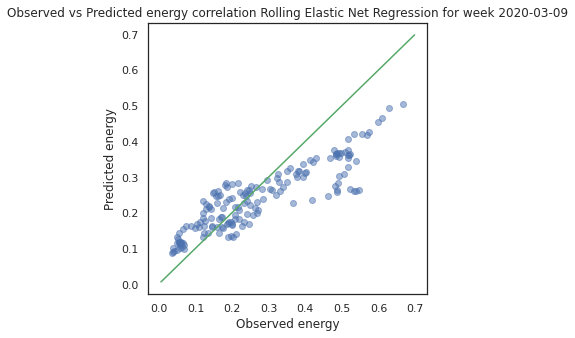

Root Mean Squared Error (RMSE): 0.09751
Mean Absolute Error (MAE): 0.07728
Finished forecasting week 2020-03-09 in 0:00:13.615344

Starting Elastic Net Regression for week 2020-05-18 for week 2020-05-18...



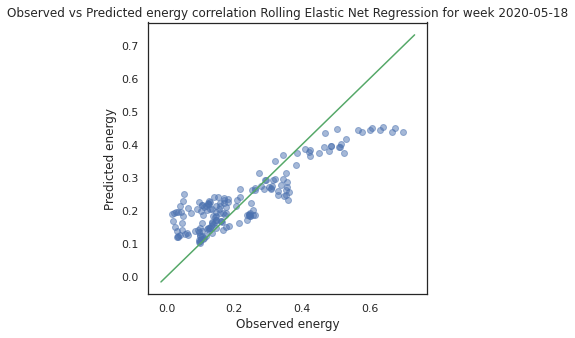

Root Mean Squared Error (RMSE): 0.08594
Mean Absolute Error (MAE): 0.06819
Finished forecasting week 2020-05-18 in 0:00:08.908072

Starting Elastic Net Regression for week 2020-07-20 for week 2020-07-20...



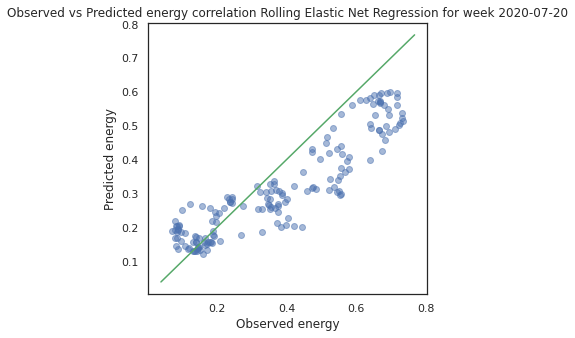

Root Mean Squared Error (RMSE): 0.12013
Mean Absolute Error (MAE): 0.09742
Finished forecasting week 2020-07-20 in 0:00:08.364233

Starting Elastic Net Regression for week 2020-10-12 for week 2020-10-12...



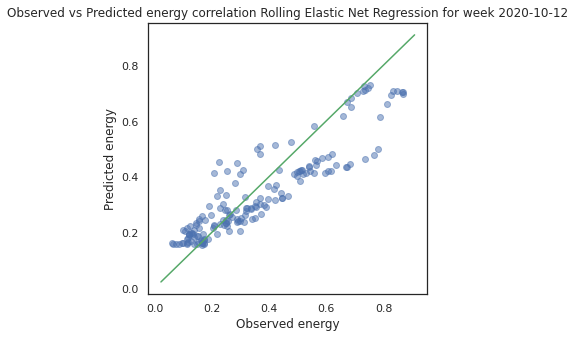

Root Mean Squared Error (RMSE): 0.09959
Mean Absolute Error (MAE): 0.07888
Finished forecasting week 2020-10-12 in 0:00:11.310622

Starting Elastic Net Regression for week 2020-12-14 for week 2020-12-14...



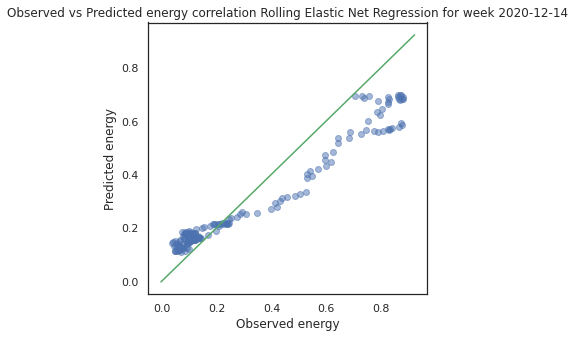

Root Mean Squared Error (RMSE): 0.11219
Mean Absolute Error (MAE): 0.09005
Finished forecasting week 2020-12-14 in 0:00:09.394565


In [11]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   l1_space = np.linspace(0, 1, 30)
   alpha_space = np.logspace(-2, 0, 10)
   param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_elnet = RandomizedSearchCV(ElasticNet(),
                                 param_grid,
                                 cv = tscv,
                                 n_jobs = 3)
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_elnet, 
                                                      'Elastic Net Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.4 Random Forest Regression


Starting Random Forest Regression for week 2020-03-09 for week 2020-03-09...



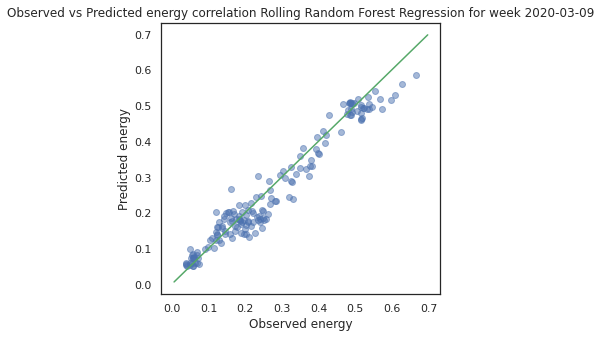

Root Mean Squared Error (RMSE): 0.03820
Mean Absolute Error (MAE): 0.03052
Finished forecasting week 2020-03-09 in 0:30:27.983893

Starting Random Forest Regression for week 2020-05-18 for week 2020-05-18...



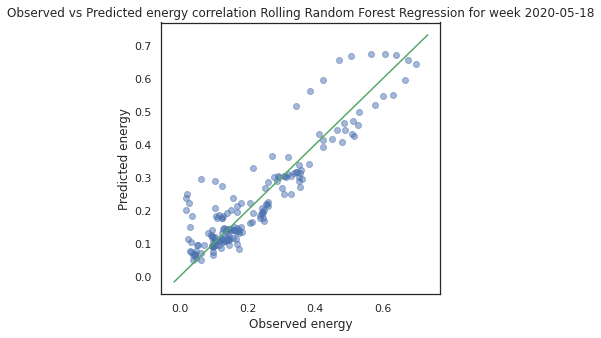

Root Mean Squared Error (RMSE): 0.06766
Mean Absolute Error (MAE): 0.04825
Finished forecasting week 2020-05-18 in 0:33:47.727673

Starting Random Forest Regression for week 2020-07-20 for week 2020-07-20...



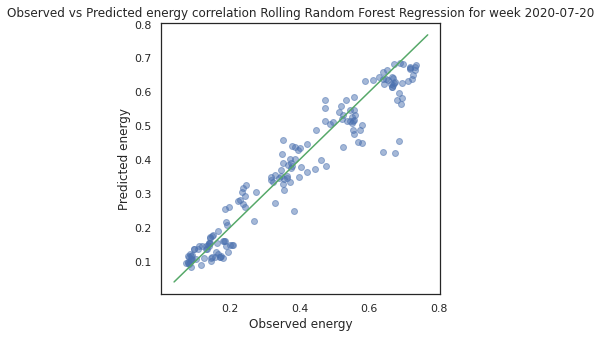

Root Mean Squared Error (RMSE): 0.05739
Mean Absolute Error (MAE): 0.04283
Finished forecasting week 2020-07-20 in 0:25:13.282060

Starting Random Forest Regression for week 2020-10-12 for week 2020-10-12...



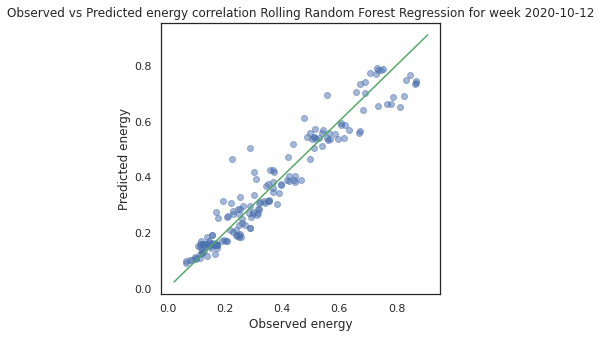

Root Mean Squared Error (RMSE): 0.05898
Mean Absolute Error (MAE): 0.04488
Finished forecasting week 2020-10-12 in 0:41:33.395401

Starting Random Forest Regression for week 2020-12-14 for week 2020-12-14...



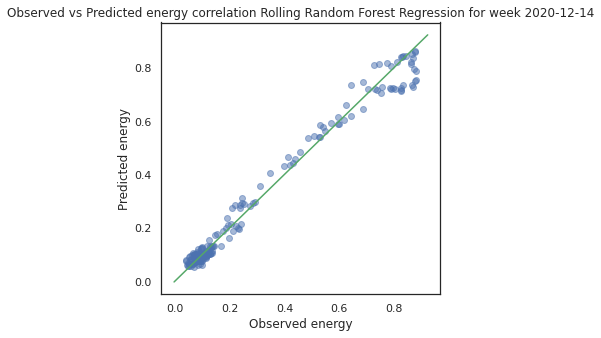

Root Mean Squared Error (RMSE): 0.04062
Mean Absolute Error (MAE): 0.02933
Finished forecasting week 2020-12-14 in 0:38:21.032609


In [12]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
   max_features = ['auto', 'sqrt']
   # Create the random grid
   param_grid = {'n_estimators': n_estimators, 
                 'max_features': max_features}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_rf = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                             param_distributions = param_grid,
                             scoring='neg_mean_squared_error',
                             cv = tscv,
                             verbose=0,
                             n_jobs = 3)
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_rf, 
                                                      'Random Forest Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.5 Extreme Gradient Boost


Starting Extreme Gradient Boost for week 2020-03-09 for week 2020-03-09...



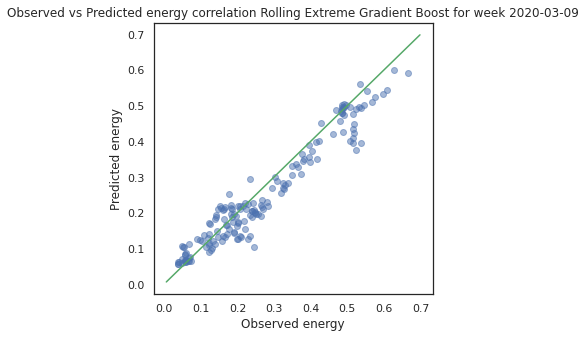

Root Mean Squared Error (RMSE): 0.04667
Mean Absolute Error (MAE): 0.03674
Finished forecasting week 2020-03-09 in 0:04:44.546982

Starting Extreme Gradient Boost for week 2020-05-18 for week 2020-05-18...



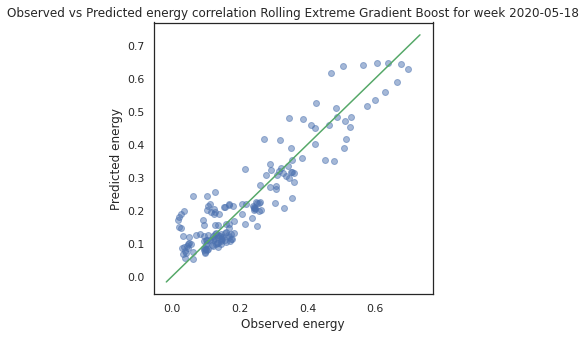

Root Mean Squared Error (RMSE): 0.06353
Mean Absolute Error (MAE): 0.04923
Finished forecasting week 2020-05-18 in 0:04:36.244836

Starting Extreme Gradient Boost for week 2020-07-20 for week 2020-07-20...



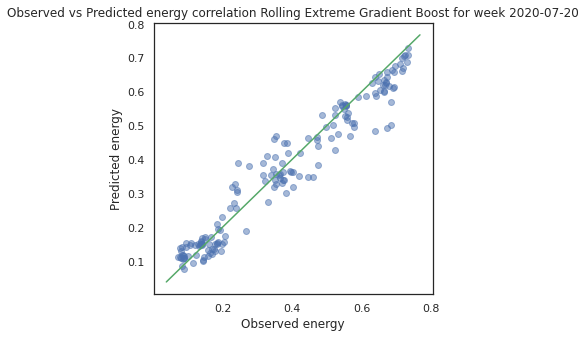

Root Mean Squared Error (RMSE): 0.05206
Mean Absolute Error (MAE): 0.04011
Finished forecasting week 2020-07-20 in 0:04:28.596995

Starting Extreme Gradient Boost for week 2020-10-12 for week 2020-10-12...



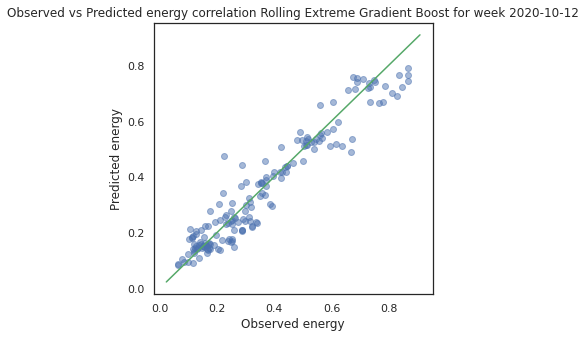

Root Mean Squared Error (RMSE): 0.06132
Mean Absolute Error (MAE): 0.04585
Finished forecasting week 2020-10-12 in 0:06:13.293094

Starting Extreme Gradient Boost for week 2020-12-14 for week 2020-12-14...



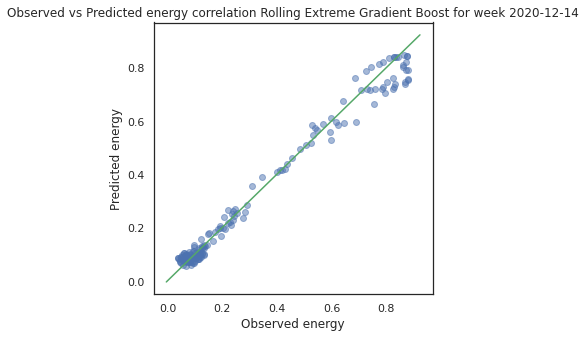

Root Mean Squared Error (RMSE): 0.03874
Mean Absolute Error (MAE): 0.02790
Finished forecasting week 2020-12-14 in 0:06:29.855547


In [13]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   param_grid = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_xgb = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error',
                                n_iter=20,
                                n_jobs = 3, 
                                cv=tscv,
                                verbose=0,
                                random_state=42)
   
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_xgb, 
                                                      'Extreme Gradient Boost for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.6 Facebook Prophet

FBProphet provides a decomposition regression model that is extendable and configurable with interpretable parameters. Prophet frames the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series. Similar to SARIMAX, we can add extra regressor terms like temperature data to the model as well.

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

In the solar energy production forecast experiment, the following seasonalities are explored:
* daily
* weekly
* yearly
* winter/summer seasonality

The **wind speed, gust and last day's solar energy generation** are added as external regressors.


Starting FB Prophet for week 2020-03-09 for week 2020-03-09...



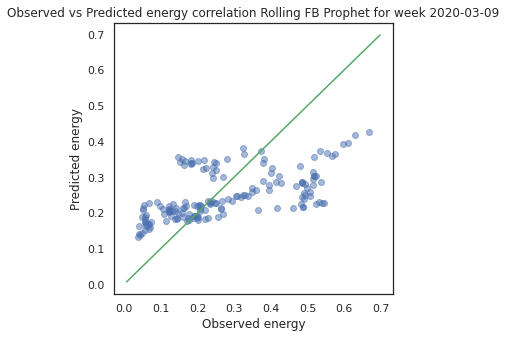

Root Mean Squared Error (RMSE): 0.13687
Mean Absolute Error (MAE): 0.11114
Finished forecasting week 2020-03-09 in 0:03:21.835760

Starting FB Prophet for week 2020-05-18 for week 2020-05-18...



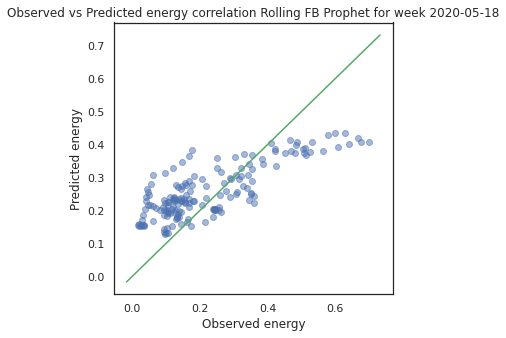

Root Mean Squared Error (RMSE): 0.11260
Mean Absolute Error (MAE): 0.09476
Finished forecasting week 2020-05-18 in 0:03:17.871835

Starting FB Prophet for week 2020-07-20 for week 2020-07-20...



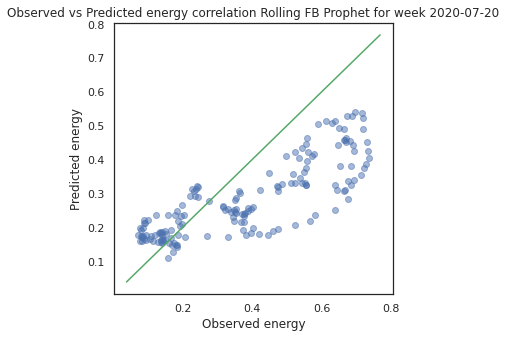

Root Mean Squared Error (RMSE): 0.16816
Mean Absolute Error (MAE): 0.13667
Finished forecasting week 2020-07-20 in 0:03:26.653222

Starting FB Prophet for week 2020-10-12 for week 2020-10-12...



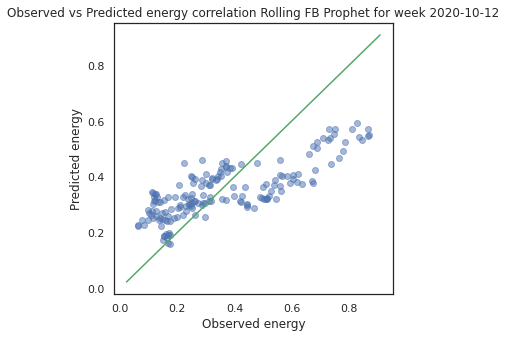

Root Mean Squared Error (RMSE): 0.15104
Mean Absolute Error (MAE): 0.12853
Finished forecasting week 2020-10-12 in 0:04:08.349424

Starting FB Prophet for week 2020-12-14 for week 2020-12-14...



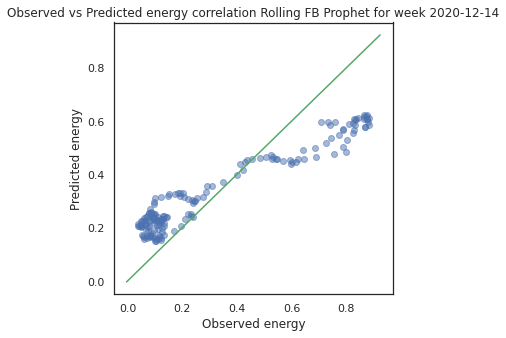

Root Mean Squared Error (RMSE): 0.15339
Mean Absolute Error (MAE): 0.13384
Finished forecasting week 2020-12-14 in 0:04:22.896345


In [14]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'FB Prophet for week %s' % str(date), 
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)

### 2.6 Hybrid Models

We combine the FB Prophet additive model with a non-linear regresson such as Random Forest and Extreme Gradient Boost. The proposed hybrid models will attemp to capture the linearity of the timeseries with the FB Prophet model and the residuals with the non-linear models.

We use the trend as captured by the FB Prophet and we extract it from the original data. We attempt to forecast the new detrended timeseries using the non-linear models.

#### 2.6.1 Hybrid model FB Prophet and Random Forest


Starting Hybrid FB Prophet and Random Forest for week 2020-03-09 for week 2020-03-09...



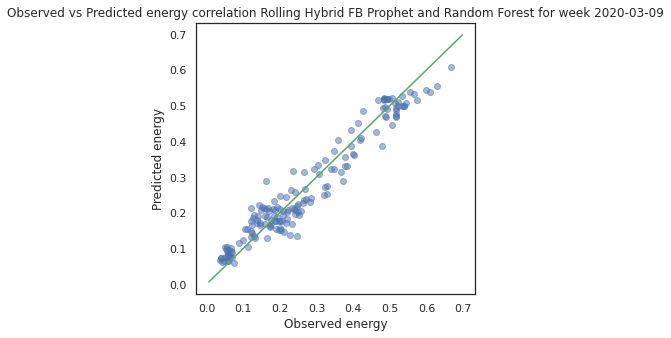

Root Mean Squared Error (RMSE): 0.04124
Mean Absolute Error (MAE): 0.03482
Finished forecasting week 2020-03-09 in 0:26:15.411875

Starting Hybrid FB Prophet and Random Forest for week 2020-05-18 for week 2020-05-18...



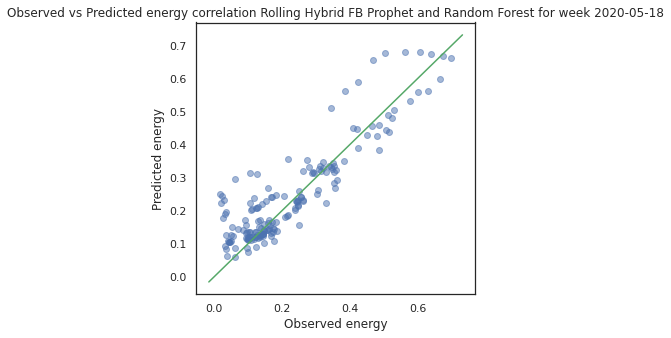

Root Mean Squared Error (RMSE): 0.07361
Mean Absolute Error (MAE): 0.05201
Finished forecasting week 2020-05-18 in 0:27:56.803300

Starting Hybrid FB Prophet and Random Forest for week 2020-07-20 for week 2020-07-20...



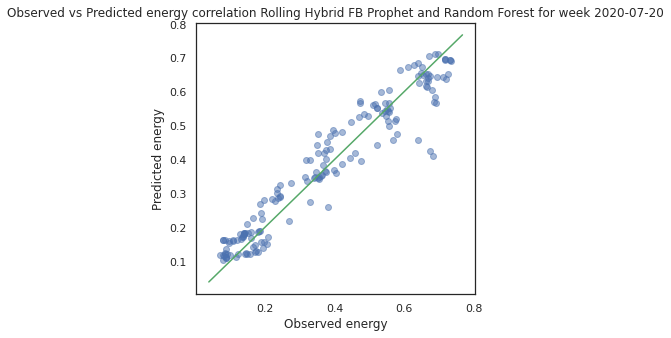

Root Mean Squared Error (RMSE): 0.06031
Mean Absolute Error (MAE): 0.04709
Finished forecasting week 2020-07-20 in 0:26:51.127870

Starting Hybrid FB Prophet and Random Forest for week 2020-10-12 for week 2020-10-12...



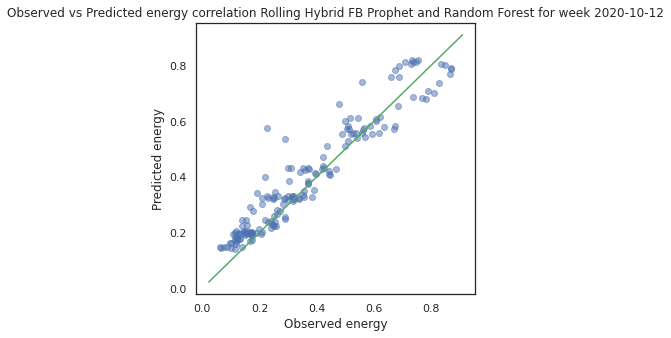

Root Mean Squared Error (RMSE): 0.07183
Mean Absolute Error (MAE): 0.05426
Finished forecasting week 2020-10-12 in 0:38:42.842228

Starting Hybrid FB Prophet and Random Forest for week 2020-12-14 for week 2020-12-14...



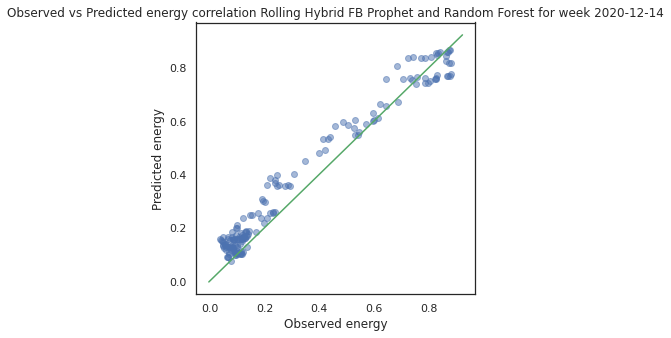

Root Mean Squared Error (RMSE): 0.06791
Mean Absolute Error (MAE): 0.05606
Finished forecasting week 2020-12-14 in 0:45:20.932261


In [15]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
   max_features = ['auto', 'sqrt']
   # Create the random grid
   param_grid = {'n_estimators': n_estimators, 
                 'max_features': max_features}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_rf = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                             param_distributions = param_grid,
                             scoring='neg_mean_squared_error',
                             cv = tscv,
                             verbose=0,
                             n_jobs = 3)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'Hybrid FB Prophet and Random Forest for week %s' % str(date), 
                                                         hybrid=True,
                                                         hybrid_model=clf_rf,
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)


#### 2.6.2 Hybrid model FB Prophet and Extreme Gradient Boost


Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-03-09 for week 2020-03-09...



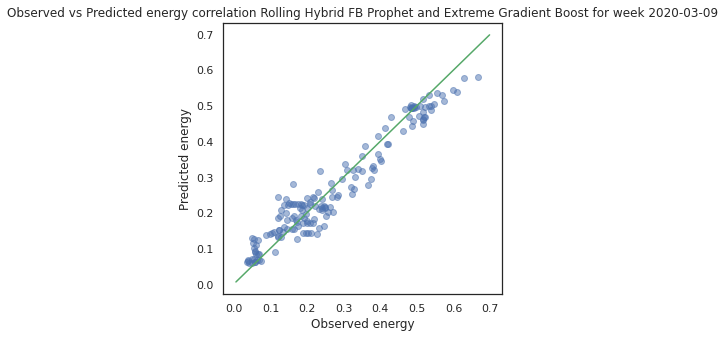

Root Mean Squared Error (RMSE): 0.04362
Mean Absolute Error (MAE): 0.03563
Finished forecasting week 2020-03-09 in 0:08:06.378476

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-05-18 for week 2020-05-18...



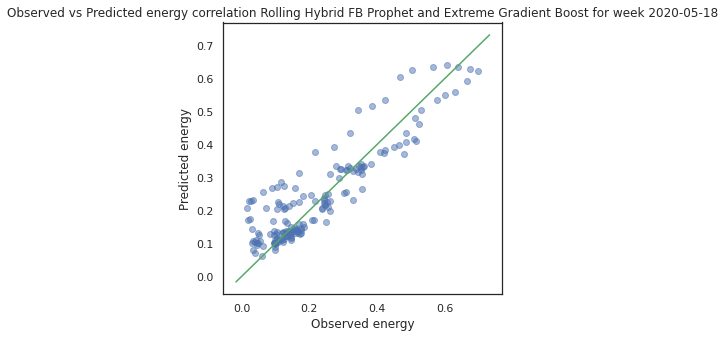

Root Mean Squared Error (RMSE): 0.07154
Mean Absolute Error (MAE): 0.05203
Finished forecasting week 2020-05-18 in 0:08:00.624920

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-07-20 for week 2020-07-20...



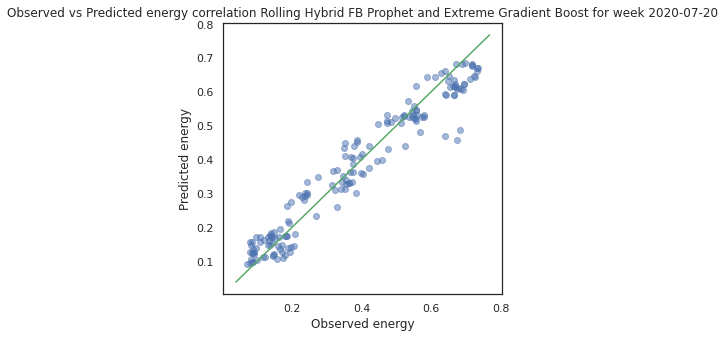

Root Mean Squared Error (RMSE): 0.05314
Mean Absolute Error (MAE): 0.04289
Finished forecasting week 2020-07-20 in 0:07:52.920334

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-10-12 for week 2020-10-12...



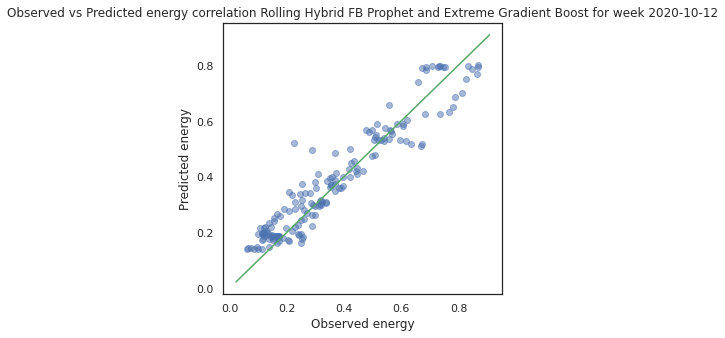

Root Mean Squared Error (RMSE): 0.06840
Mean Absolute Error (MAE): 0.05333
Finished forecasting week 2020-10-12 in 0:10:34.960338

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-12-14 for week 2020-12-14...



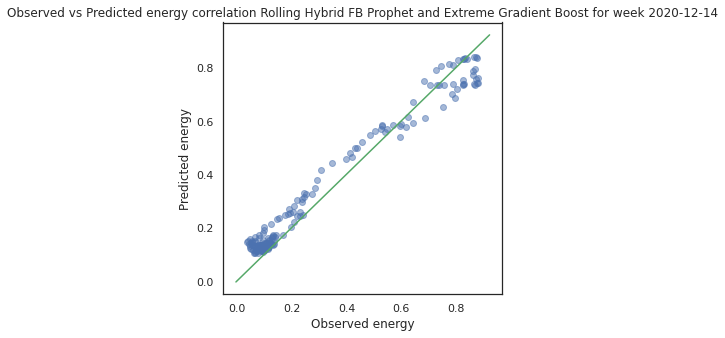

Root Mean Squared Error (RMSE): 0.06070
Mean Absolute Error (MAE): 0.05116
Finished forecasting week 2020-12-14 in 0:11:00.004512


In [16]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   param_grid = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_xgb = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error',
                                n_iter=20,
                                n_jobs = 3, 
                                cv=tscv,
                                verbose=0,
                                random_state=42)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'Hybrid FB Prophet and Extreme Gradient Boost for week %s' % str(date), 
                                                         hybrid=True,
                                                         hybrid_model=clf_xgb,
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)


## 3. Final Report

The final report, contains the evaluation of the main hypothesis using MAE and RMSE metrics as well as the violin plot of the error distribution, as error we define the absolute difference of the prediction and the expected value.

In [17]:
report_df = pd.DataFrame.from_dict(rolling_eval.model_comparison_dict).T
# report_df.drop(columns='diff', inplace=True)
report_df.loc[:, 'MAE'] = pd.to_numeric(report_df['MAE'])
report_df.loc[:, 'RMSE'] = pd.to_numeric(report_df['RMSE'])

model_list = list(set([k[:k.find('for')-1]
                       for k in set(list(rolling_eval.model_comparison_dict.keys()))]))

for date in target_dates:
   report_df.loc[report_df.index.str.contains(str(date)), 'week'] = date
   
for model in model_list:
   report_df.loc[report_df.index.str.contains(pat='^%s\s+for' % model), 'model'] = model.replace('Rolling ', '')


Below is the MAE and RMSE for each model and each week

In [18]:
for metric in ['MAE', 'RMSE']:
   fig = px.bar(report_df, x="week", y=metric, 
                      color="model", hover_name="model", 
                      barmode="group", title='%s Evaluation' % metric)
   fig.show()

Model performance averaged for all weeks

In [19]:
report_df.reset_index().groupby(by=['model']).mean().sort_values('RMSE')

MAE      RMSE
model                                                           
Extreme Gradient Boost                        0.039966  0.052464
Random Forest Regression                      0.039162  0.052570
Hybrid FB Prophet and Extreme Gradient Boost  0.047008  0.059480
Hybrid FB Prophet and Random Forest           0.048848  0.062980
Linear Regression                             0.051074  0.066368
Ridge Regression                              0.051584  0.067500
Elastic Net Regression                        0.082364  0.103072
FB Prophet                                    0.120988  0.144412

In [20]:
for metric in ['MAE', 'RMSE']:
   df = report_df.groupby(by=['model']).mean().reset_index().sort_values(metric).reset_index()

   fig = px.bar(df, x="model", y=metric, 
                color="model", hover_name="model", 
                title='Average %s of all test weeks' % (metric))
   fig.show()

Error distribution visualization using violin plot. The error distribution for each model and each week is presented

In [21]:
error_diff_df = pd.DataFrame.from_dict({k:rolling_eval.model_comparison_dict[k]['diff'] for k in rolling_eval.model_comparison_dict.keys()})

model_index = [c for col in [len(error_diff_df)*[col] for col in error_diff_df.columns] for c in col ]
diff = [a for array in [error_diff_df[col].values for col in error_diff_df.columns] for a in array]

report_diff_df = pd.DataFrame.from_dict({'model_index': model_index, 'error_diff': diff})

for date in target_dates:
   report_diff_df.loc[report_diff_df['model_index'].str.contains(str(date)), 'week'] = date
   
for model in model_list:
   report_diff_df.loc[report_diff_df['model_index'].str.contains(pat='^%s\s+for' % model), 'model'] = model.replace('Rolling ', '')


In [22]:
for week in report_diff_df['week'].unique():
   df = report_diff_df.loc[report_diff_df['week']==week]
   fig = px.violin(df, 
                   x="model",
                   y="error_diff", 
                   color='model', 
                   title='Boxplot of error distribution for week %s' % (week), 
                   box=True, # draw box plot inside the violin
                   points='outliers')
   fig.show()